In [1]:
import numpy as np
from matplotlib.path import Path
from matplotlib import pyplot as plt
import pickle

import sys
sys.path.insert(0,'./src/')

from utils import *
from pipe import *
from pipe_system import PipeSystem
from abstract_pipe import *

In [2]:
with open('dev_Pipes.pickle','rb') as f:
    pipes, shifts = pickle.load(f)

In [3]:
bdr_pipe = BoundaryPipe([BoundaryLet(-10,0,0,2,1),BoundaryLet(36,0,np.pi,2,-1)])
real_pipes = [RealPipe(p,shift_x=shift[0],shift_y=shift[1]) for p,shift in zip(pipes,shifts)]
ps = PipeSystem(real_pipes,bdr_pipe)

AttributeError: 'RealPipe' object has no attribute 'shift'

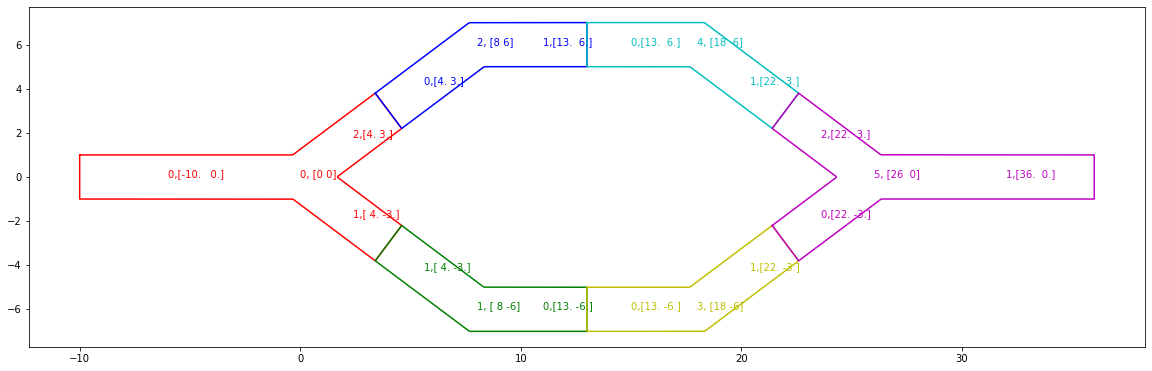

In [8]:
color = ['r','g','b','y','c','m','k']

fig,ax = plt.subplots(figsize=(20,10))
ax.set_aspect('equal')

for a,i,j,c in zip(range(10),pipes,shifts,color):
    ax.plot(*(i.closed_boundary + j).T,c=c)
    for k,let in enumerate(i.lets):
        ax.text(*(0.6*let.matching_pt + j),f'{k},{let.matching_pt + j}',color=c)
    ax.text(*j,f'{a}, {j}',color=c)

In [21]:
u_field = []
v_field = []
p_field = []
o_field = []

xs = []
ys = []

unexplored = set(range(len(ps.pipes)))
open = []

pipe_index = 0
let_index = 0
pressure_at_let = 0

while True:

    # taking data
    pipe = pipes[pipe_index]
    shift = shifts[pipe_index]
    xs.append(shift[0]+pipe.xs)
    ys.append(shift[1]+pipe.ys)

    fluxes = ps.fluxes_of_pipe(pipe_index)

    u, v, p, o = pipe.fields_with_fluxes(fluxes, let_index, pressure_at_let)
    
    u_field.append(u)
    v_field.append(v)
    p_field.append(p)
    o_field.append(o)

    # marking explored
    unexplored.remove(pipe_index)

    if not unexplored:
        break
    
    # updating opens

    for other_let_index in range(len(pipe.lets)):
        if other_let_index == let_index:
            continue
        l1 = LetIndex(pipe_index, other_let_index)
        v = ps.let2vertex[l1]
        l2 = v.l1 if v.l1 != l1 else v.l2
        another_pipe_index = l2.pipeIndex
        if another_pipe_index not in unexplored:
            continue
        another_base_pressure = real_pipes[pipe_index].pressure_at_let(
            fluxes, other_let_index, let_index, pressure_at_let)
        another_let_index = l2.letIndex

        open.append((another_pipe_index, another_let_index, another_base_pressure))
        
    
    if not open:
        raise Exception('No more open pipes')
    
    pipe_index, let_index, pressure_at_let = open.pop()


In [22]:
xs = np.concatenate(xs)
ys = np.concatenate(ys)
u_field = np.concatenate(u_field)
v_field = np.concatenate(v_field)
p_field = np.concatenate(p_field)
o_field = np.concatenate(o_field)

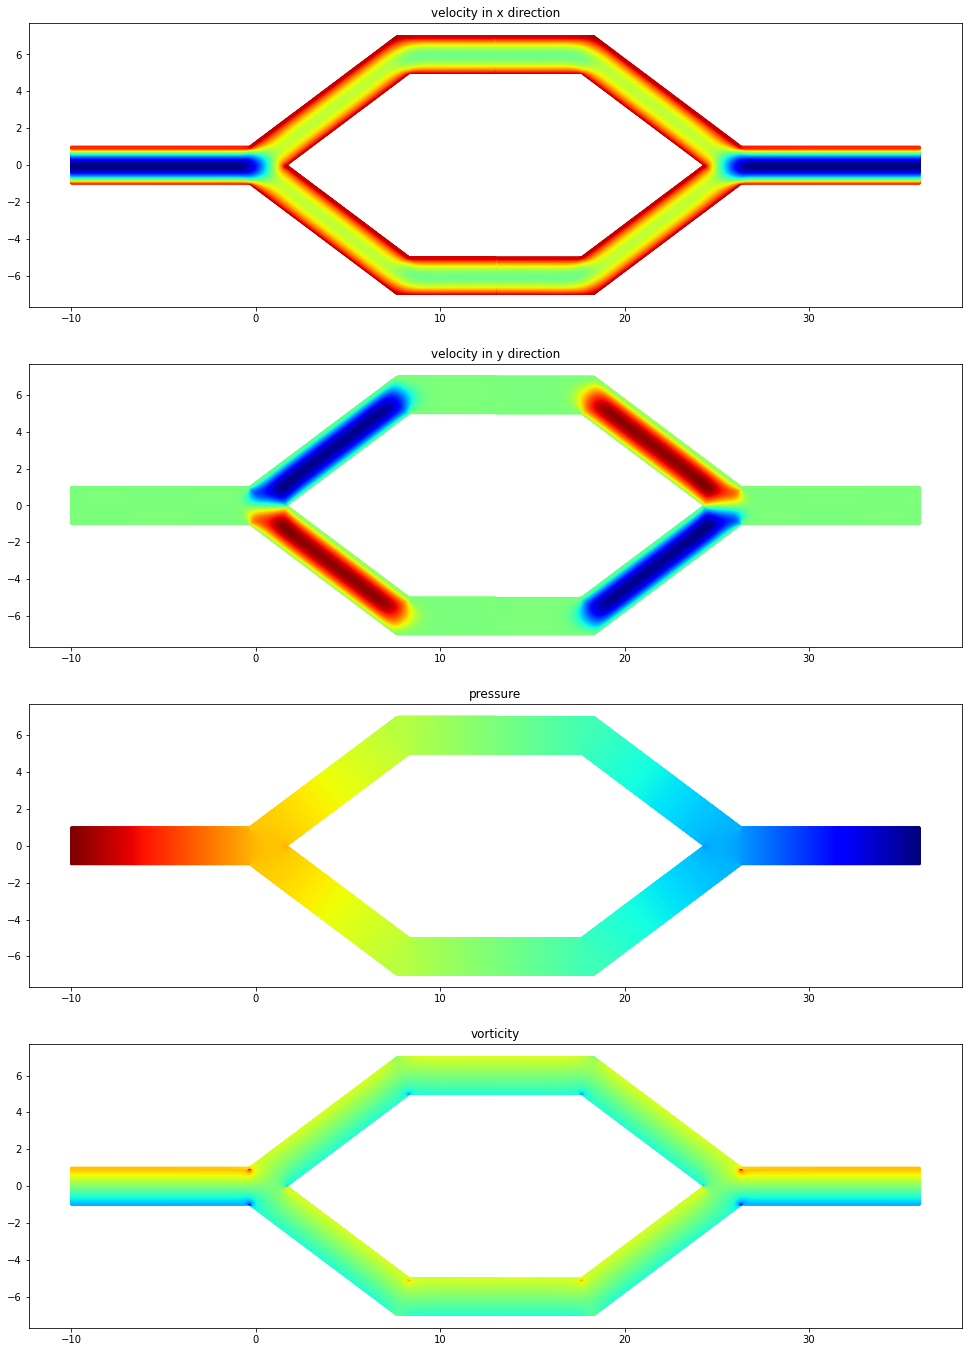

In [36]:
fig,axes = plt.subplots(4,1,figsize=(20,24))

for ax, field, title, in zip(axes, [u_field,v_field,p_field,o_field], ['velocity in x direction','velocity in y direction','pressure','vorticity']):
    ax.set_aspect('equal')
    ax.scatter(xs,ys,c=field,s=1,cmap='jet')
    ax.set_title(title)